# Gender Bias within Text Data

Recently, the United Nations found that the language based models within the inner workings of Siri (Apple's AI) , Alexa(Amazon's AI), and Google Assistant (Google's AI) reinforce gender bias.
https://www.nytimes.com/2019/05/22/world/siri-alexa-ai-gender-bias.html

Since the training data for most of the language models are the root source of the problem since NLP models are trained under the notion of supervised learning which could reinforce gender bias if the training data was inherently biased. 

Within this tutorial I am to show the multiple different reasons as to why these models are inherently biased. Rather than looking into the inner workings of the machine learning model, we will treat the model as a blackpbox and explore the text data itself to measure which characteristics within the text data is inherently biased.

For this Tutoria I aim to show the different data science techniques in Natural Language Processing in order to uncover the various gender biases that we see with text data. I will use the Wikipedia Dataset for some models but will also use the Google News Data set as well. 

### Dependencies/Requirements

1) (Already in this project) You will need to download the Google News dataset which can be found here (Be sure to place in the same directory): https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

2) You also need to have genisum: Genism Installation: https://pypi.org/project/gensim/

3) You will also need to install sklearn for the t-SNE plot: https://scikit-learn.org/stable/install.html

In [24]:
import os
from io import open
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import gensim as gs
from sklearn.manifold import TSNE
import numpy as np

## Overview
We will look at text data in order to discover the different ways that the text is inherently gender biased. 

1. **Word2Vec Model**: Covering why the word to vector models are inherently gender biased
2. **T-SNE**: Visualizing the gender bias of word to vector model representations 
3. **Debiasing Techniques for a Word2Vec Model**: Using numpy and some vector/matrix manipulation to reduce the bias within word vectors

### Word Vector Model



What we first want to is do determine the words that are mainly associated with different genders in order to identify the types of words that are associated with a man vs a woman. To do this we will use the word vector model that was shown from the genism library using the Google dataset. 

This dataset has roughly 3 million unique text data tokens which means that the word2vec models will produce very accurate results for the associations of different words.

In [25]:
model = gs.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)


Based on the Paper "Man is computer Programmar as women is to home-maker", we can take a look at the word vector model between the association of the occupation. Through the example of a man, woman, queen and king. We would expect that the relationship between man and king is similar to the relationship between woman and queen. This is because word vector models are trained to run on context driven analysis where words are correlated to each other based on context alone.

In [26]:
"A simple function that excludes the word vector that will exclude the original word from the list of vectors"
def notSameWord(vec, referenceStr):
    result = []
    for point in vec:
        word = point[0]
        if(not(word == referenceStr)):
            result.append(point)
    return result

"Making a to String function for the word vectors"
def toString(wordPoints):
    for dataPoint in wordPoints:
        print("Word: " + dataPoint[0] + ", Relationship Strength: " + str(dataPoint[1]))

In [27]:
vector_queen = model.wv.similar_by_vector(model.wv["king"] - model.wv["man"] + model.wv["woman"], topn=3)  
top_word = notSameWord(vector_queen, "king")
toString(top_word)

/Users/aashaiavadhani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


Word: queen, Relationship Strength: 0.7300517559051514
Word: monarch, Relationship Strength: 0.6454660892486572


We find here that the most correlated word related to woman, associated with king, is queen. This proves our concept that there is no other confounding variable that is affecting the way word vector models are trained. This simply shows us that the results of the word2vec models are purely from the training of the size of the dataset and the type of text data.

However, this is not good. Since there are no set variablaes to which the word vector models are trained upon, the models can produce some troubling results for words that are associated with gender, race, sexism, and other words as well. We find that with a large training dataset, that certain words will be associated more with the male gender, compared to the female gender. For example, for stereotype sake,  we typically believe that the occupation of a plumber is more associated with a male rather than a female. We find that the word vector model supports this: 

In [28]:
vector_homemaker = notSameWord(model.wv.similar_by_vector(model.wv["plumber"] - model.wv["he"] + model.wv["she"], topn=3), "plumber")
top_word = notSameWord(vector_homemaker, "plumber")
toString(top_word)

/Users/aashaiavadhani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


Word: hairdresser, Relationship Strength: 0.6336162686347961
Word: beautician, Relationship Strength: 0.6142419576644897


From this we clearly see that the relationship between a plumber and a man is the same as a woman is to a hairdresser according the word vector model. Not only can these models are producing gender biased data, but the relationship between race and other words are alarmingly different such as the association between criminal and race. 

In [29]:
#The similarity used is cosine similarity from the genism library
print("Association between criminal and black: ", model.similarity("criminal", "black"))
print("Association between criminal and white: ",model.similarity("criminal", "white"))

Association between criminal and black:  0.08380793
Association between criminal and white:  0.041078076


This is quite alarming given that the association between a criminal and the race black is almost double the strength than the relationship between criminal and the race white. This furthermore proves that we have to be extremely careful with the word vector models that exist today since they clearly support these types of biases. This also sheds some light regarding the text data itself and that the text data we have in the news and other sources are clearly biased in terms of gender and race.  

This is also shows us that word 2 vector/word embeddings are models that dont take into consideration biases. They simply produce results based on the data they are given. 

## Visualizing Word Embeddings using T-SNE

Still using the Google dataset, we will visualize different word embeddings for different words using a T-SNE. A T-SNE stands for a T-Distributed Stochastic Neighboring Embedding model that is a very good machine learning algorithim for visualizing datasets with high-dimension variables. For our case, the t-SNE will show the different words within the language model that are related to the keyvalues that we are searching for.

For example, we expect to see a cluster of words that are expected to be from the male gender (such as king, plumber, etc..) vs the female gender (such as queen, hairdresser etc...) and see the inherent differences between these words. 

For this T-SNE we will use the keywords as programmer and homemaker since these are the two most common words suprisingly associated with male and female stereotypes within many datasets. I also received inspiration from the paper 
Man is to Computer Programmer as Woman is to Homemaker?<sup>1</sup> regarding the methods to debiasing word embedding models which we will cover later in this tutorial. These two words are proven to clearly biased based on gender where you can see below for the results.

In [30]:
similarity_man_prog = model.similarity('programmer','man')
similarity_man_homemaker = model.similarity('programmer','woman')
similarity_woman_prog = model.similarity('programmer','woman')
similarity_woman_homemaker = model.similarity('homemaker','woman')


print("Programmer:")
print("Similarity between programmer and man: ", similarity_man_prog)
print("Similarity between programmer and woman: ", similarity_woman_prog)
print("************************************************************************")
print("Homemaker:")
print("Similarity between homemaker and man: ", similarity_man_homemaker)
print("Similarity between homemaker and woman: ", similarity_woman_homemaker)




Programmer:
Similarity between programmer and man:  0.126169
Similarity between programmer and woman:  0.08992715
************************************************************************
Homemaker:
Similarity between homemaker and man:  0.08992715
Similarity between homemaker and woman:  0.40326244


Since there is a clear similarity that is stronger for homemaker and woman/programmer and man, we will use these two words as a key reference phrase points for the t-SNE plot

In [31]:

keys = ['programmer','homemaker']


"This code gathers and returns the word embeddings for all the most similar words for the key phrases"
def getClusters(keys):
    embedCluster = []
    wordCluster = []
    for word in keys:
        embeddings,words = [], []
        modelSimilarWords = model.most_similar(word, topn=40)
        
#Need to iterate through the word and its embedding, thus temp var is needed
        for similar_word, temp in modelSimilarWords:
            words.append(similar_word)
            embeddings.append(model[similar_word])
            
        embedCluster.append(embeddings)
        wordCluster.append(words)
        
    return (embedCluster,wordCluster)


embedding = getClusters(keys)[0]
wordClustering = getClusters(keys)[1]


We will use the TSNE library to show some visualizations about the different key words. For this case we will use the man and woman example.  

Using a 'pca' (Principle Component Analysis) means that we are observing the transformation from correlated to uncorrelated values within the observation points. This is crucial since we do not want to show any other type of uncorrelated variables within the datapoints. This also completes the function of transforming the T-SNE from multiple dimensions into a lower dimensional analysis.

The perplexity value also helps us determine the nearest neighbors within each word. The perlexity value helps us determine this since the perplexity value is the conditional probability that we will find a word similar to another keyword value. 

In [32]:
#Setting up the clustering for the T-SNE

embedding_clusters = np.array(embedding)
n, m, k = embedding_clusters.shape

#Creating the TSNE model
#n iter allows for optimization of the model
#the random state produces the random number if the case for some values is None
tsne_model_en_2d = TSNE(perplexity=30, n_components=2, init = 'pca' ,n_iter=4000, random_state=35)

#transformes the embedding cluster model to 2 dimensions
transform2DEmbedding = tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))

#creating an array in order to 
array2DEmbedding = np.array(transform2DEmbedding)
finalEmbedding2D = array2DEmbedding.reshape(n, m, 2)



Now that we have the embedding and the TSNE model prepared, we can plot the data points onto a scatterplot. Essentially within this code, we are plotting all the words that are near the key phrase words.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


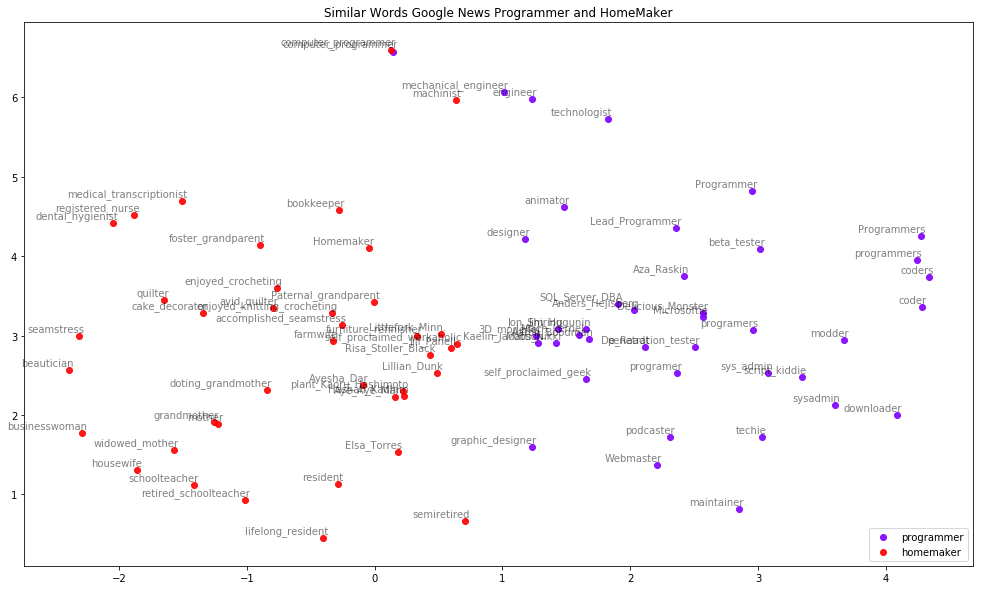

In [33]:
def plotTSNE(title, labels, embedding_clusters, word_clusters, a, filename=None):
    
    #creating the plot
    plt.figure(figsize=(17, 10))
    num_labels = len(labels)
    color = cm.rainbow(np.linspace(0, 1, num_labels))
    zippedData = zip(labels, embedding_clusters, word_clusters, color)
    for label, embeddings, words, color in zippedData:
        x, y = embeddings[:, 0], embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        
        #getting the word neighbors
        wordEnumeration = enumerate(words)            
        #labeling the embedding coordinates with their corresponding word
        for locationEmbedding, word in wordEnumeration:
            plt.annotate(word, alpha=0.5, xy=(x[locationEmbedding], y[locationEmbedding]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=10)

    plt.title(title), plt.legend(loc = 4)
    plt.show()
    
    

plotTSNE('Similar Words Google News Programmer and HomeMaker', keys, finalEmbedding2D, wordClustering, 0.9)

As we can see from this visualization that similar professions for each of the programmer vs homemaker classifications from the word model. We see that the most similar words (excluding the pronouns) show that there is a clear distinction between the words associated with man as opposed to woman. The homemaker is associated more with widowed_mother, grandmother, and actual names of identified woman (Ayesha, Risa, etc...). Meanwhile the programmer is associated more with the male dominated professions such as lead programmer, coder, and also names of identified males. There is also a clear division between the types of jobs dominated by men and woman. Since we see that woman also mainly associated with homemaker, then womans nearest neighbors will also be close to the neighbors for the homemaker profession. Likewise for the programmer profession.

### Debiasing Techniques for Word Embeddings

This section is inspiration from the Man is to Computer Programmer as Woman is to Homemaker? paper

In order to perform accurate deibasing within word models, we have to change the way the embeddings are measured when the model is executed on the dataset. The steps we need to take in order to perform accurate de biasing are:

1. Identifying the gender subspace
2. Then Neutralize(or Soften) the data

From this approach we would be able eliminate most of the biases from the word embedding model. Rather than using a different model such as an LSTM or an RNN like most complex deep learning language models, we would rather use a more mathematical approach to eliminate the bias. 


The subspace we are looking for within the data is the gender subpace which is where the bias lies in. The gender bias subspace is defined by the orthogonal vector units $$B =  \{b_{\text{1}}, ......, b_{\text{k}}\} \subseteq R^{d} $$
Where $b_{\text{k}}$ is a unit vector. B represents the gender subspace that represents the bias. In terms of the code, this will simply be the subtraction of the vector between woman and man.

$$ v_{\text{B}} = \frac{v \cdot B}{||B|| ^ 2 _ 2} * B$$

From this we can infer that the projection onto the orthogonal space is $$ v - v_{\text{B}} $$

*Referenced from Man is to Computer Programmer as Woman is to Homemaker*

From this logic, we aim to find the gender bias space, neutralize the bias from the word, and equalize the words from the bias. V

Lets translate this logic into code:

Identifying the gender bias subspace is simply obtaining the vector of woman - man since that is the bias we are trying to eliminate from the set. 

In [11]:
biased_space = model.wv['woman'] - model.wv['man']

/Users/aashaiavadhani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


For common practice, we will use cosine similarity since that is the standard similarity test for comparing two words. As a reminder the cosine equation is defined as:



$$ cos(u,v) = \frac{u \cdot v}{||u|| \space ||v||}  $$



In [12]:
def cosine_similarity(u, v):
    
    # Compute the dot product between u and v
    dot = np.dot(u, v)
    
    # Compute the norms of each of the vectors
    norm_u, norm_v = np.sqrt(np.sum(u**2)),  np.sqrt(np.sum(v**2))

    # Compute the cosine similarity defined by formula (1) (≈1 line)
    cosine_similarity = dot / (norm_u * norm_v)
    return cosine_similarity

The next step is to neutralize the gender bias. We take this as the the $v - v_{\text{B}}$
From this we say that $ v_{\text{B} }$ is the projection of the word onto the gender biased space: B. Using the equation defined above $v_{\text{B}} = \frac{v \cdot B}{||B|| ^ 2 _ 2} * B$ we can easily find the biased part of the word component.


In [13]:
"""
Given a word and the biased space, this function will neutralize the bias from the word by finding the biased component 
and subtracting the original vector by the particular biased component. 
"""
def neutralizeWord(word, biased_space, w2v_map):
    num = (np.dot(w2v_map[word], biased_space))
    denom = (np.linalg.norm(biased_space) ** 2)
    biased_component = (num / denom) * biased_space
    return w2v_map[word] - biased_component

"""
Given a vector and the biased space, this function will neutralize the bias from the word by finding the biased component 
and subtracting the original vector by the particular biased component. 
"""
def neutralizeVector(vector , biased_space, w2v_map):
    num = (np.dot(vector, biased_space))
    denom = (np.linalg.norm(biased_space) ** 2)
    biased_component = (num / denom) * biased_space
    return vector - biased_component


"""
Finding the biased part of the vector by dividing the dot product by the norm, multiplied by the biased space
"""
def findBiasedComponent(vector, biased_space):
    num  = (np.dot(vector, biased_space))
    denom = (np.linalg.norm(biased_space) ** 2)
    biased_component = (num/ denom) * biased_space
    return biased_component

The code for neutralizing the different word vectors when comparing two words. For example, we would like to equalize the word association between man and woman. Now we can implement this neutralization between the two vectors.

Now after we neutralize the word vector, the next step is to equalize the vector for the two words. We do this by first finding the mean vector of the two words and neutralize the mean vector for that point. From the biased component we must adjust the bias of each of the biased components in order to make the two word vectors orthogonal. 

In [14]:

'''
The function normalizes the vector based on the biased space vector 
'''
def adjustToCorrect(neutralVector, wordVector, biasedSpaceVector, error):
    denom = np.linalg.norm(wordVector-neutralVector-biasedSpaceVector)
    numer = (np.sqrt(abs(1-np.linalg.norm(neutralVector)**2)))
    
    #adjust the vector based on the subtraction of the 
    return (numer/denom)*(error-biasedSpaceVector)

In [15]:


'''
Given two words, we would find the vector's of each and then equalize the error of the 
'''
def equalize(pairWords, biased_space, w2v_map):
    #Gathering the word vecgtors
    wordVector1, wordVector2 = w2v_map[pairWords[0]], w2v_map[pairWords[1]]
    
    wordVecMean = (wordVector1 + wordVector2) / 2

    # Find the projections of the biased an unbiased mean over the biased space
    biasedMean = findBiasedComponent(wordVecMean,biased_space)
    neutralizedMean = neutralizeVector(wordVecMean, biased_space, w2v_map)

    #Calculates the biased component which we will treat as "error" in order to creat the orthogonal vectors 
    error_wordOne, error_wordTwo = findBiasedComponent(wordVector1, biased_space), findBiasedComponent(wordVector2, biased_space)
        
    #We now adjust the vectors based on the biased components.
    adjusted_word1Bias = adjustToCorrect(neutralizedMean,wordVector1, biasedMean,error_wordOne)
    adjusted_word2Bias = adjustToCorrect(neutralizedMean,wordVector2, biasedMean,error_wordTwo)
    
    
    # Returning the equalized bias by adding the neutralized mean by the word bias
    return adjusted_word1Bias + neutralizedMean, adjusted_word2Bias + neutralizedMean
    

In [16]:
biased_space = model.wv['woman'] - model.wv['man']
print("BEFORE DEBIASING: ")
print("cosine_similarity(man, gender_biased_subspace) = ", cosine_similarity(model.wv["man"], biased_space))
print("cosine_similarity(woman, gender_biased_subspace) = ", cosine_similarity(model.wv["woman"], biased_space))
print(cosine_similarity(model.wv["man"], model.wv["woman"]))


debiased_vector_man, debiased_vector_woman = equalize(("man", "woman"), biased_space, model.wv)
print("AFTER DEBIASING: ")
print("******************************************************************************")
print("cosine_similarity(man, gender_biased_subspace) = ", cosine_similarity(debiased_vector_man, biased_space))
print("cosine_similarity(woman, gender_biased_subspace) = ", cosine_similarity(debiased_vector_woman, biased_space))
print(cosine_similarity(debiased_vector_man,debiased_vector_woman))

BEFORE DEBIASING: 
cosine_similarity(man, gender_biased_subspace) =  -0.15934694
cosine_similarity(woman, gender_biased_subspace) =  0.5120308
0.76640123
AFTER DEBIASING: 
******************************************************************************
cosine_similarity(man, gender_biased_subspace) =  -0.6684659
cosine_similarity(woman, gender_biased_subspace) =  0.66846603
0.10630651


/Users/aashaiavadhani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/Users/aashaiavadhani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/aashaiavadhani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/Users/aashaiavadhani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/aashaiavadhani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

Now we see that the vectors between man and the gender space as well as the woman and the gender space are alot less debiased. We can use these associations. We can use these vectors to show the association between words to be less biased. This means that there wont be much favoring when two words are associated with each other when comparing the word to a gender. 

In [17]:
biased_space = model.wv['homemaker'] - model.wv['woman']

print("BEFORE DEBIASING: ")
print("cosine_similarity(homemaker, gender_biased_subspace) = ", cosine_similarity(model.wv["homemaker"], biased_space))
print("cosine_similarity(woman, gender_biased_subspace) = ", cosine_similarity(model.wv["woman"], biased_space))
print("ORIGINAL VECTOR (Homemaker-woman): ",cosine_similarity(model.wv["homemaker"], model.wv["woman"]))
print("")
debiased_vector_homemaker, debiased_vector_woman = equalize(("homemaker", "woman"), biased_space, model.wv)
print("AFTER DEBIASING: ")
print("******************************************************************************")
print("cosine_similarity(homemaker, gender_biased_subspace) = ", cosine_similarity(debiased_vector_homemaker, biased_space))
print("cosine_similarity(woman, gender_biased_subspace) = ", cosine_similarity(debiased_vector_woman, biased_space))
cosine_similarity(debiased_vector_homemaker, debiased_vector_woman)
print("AFTER DEBIASING VECTOR (Homemaker-woman): ",cosine_similarity(debiased_vector_homemaker, debiased_vector_woman))


BEFORE DEBIASING: 
cosine_similarity(homemaker, gender_biased_subspace) =  0.7251324
cosine_similarity(woman, gender_biased_subspace) =  -0.33771715
ORIGINAL VECTOR (Homemaker-woman):  0.4032624

AFTER DEBIASING: 
******************************************************************************
cosine_similarity(homemaker, gender_biased_subspace) =  0.6756527
cosine_similarity(woman, gender_biased_subspace) =  -0.6756527
AFTER DEBIASING VECTOR (Homemaker-woman):  0.08698689


/Users/aashaiavadhani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/Users/aashaiavadhani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/Users/aashaiavadhani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Users/aashaiavadhani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/Users/aashaiavadhani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.

We see from this technique that by altering the way words are embedded, we are able to decrease the biased word vector representation from simple vector/matrix manipulations. There are more complex ways that are being done in research from LSTMS and RNNS to manipulate the way the models read in text for debiasing methods, but we see that from simple matrix manipulation, we are able to reduce alot of bias from the word2vec models. 

References:

1) https://arxiv.org/abs/1607.06520 (Man is to Computer Programmar as Woman is to Homemaker)

2) https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

3) https://arxiv.org/abs/1903.03862 (LipStick on a Pig: Debiasing Techniques)
